In [1]:
!pip install pytorch-tabnet
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 536 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=559dcf1833a2403799596c0cbe4444731c8f7ceced8a9ec412e49dcc10a6a61b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pytorch_tabnet.tab_model import TabNetRegressor

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np
np.random.seed(0)
from tqdm.auto import tqdm

import os
import wget
from pathlib import Path
import shutil
import gzip

from matplotlib import pyplot as plt
%matplotlib inline

# ---------tabnet 돌려보기--------

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Daycon/train_20221109_1040.csv')
test = pd.read_csv('/content/drive/MyDrive/Daycon/test_20221109_1040.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Daycon/y_train.csv')

# Load data and split
Same split as in original paper

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524074 entries, 0 to 524073
Data columns (total 27 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     524074 non-null  object 
 1   day_of_week            524074 non-null  int64  
 2   base_hour              524074 non-null  float64
 3   lane_count             524074 non-null  float64
 4   road_rating            524074 non-null  int64  
 5   maximum_speed_limit    524074 non-null  float64
 6   road_type              524074 non-null  int64  
 7   start_latitude         524074 non-null  float64
 8   start_longitude        524074 non-null  float64
 9   start_turn_restricted  524074 non-null  int64  
 10  end_latitude           524074 non-null  float64
 11  end_longitude          524074 non-null  float64
 12  end_turn_restricted    524074 non-null  int64  
 13  target                 524074 non-null  float64
 14  start_node_label       524074 non-nu

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291241 entries, 0 to 291240
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     291241 non-null  object 
 1   day_of_week            291241 non-null  int64  
 2   base_hour              291241 non-null  float64
 3   lane_count             291241 non-null  float64
 4   road_rating            291241 non-null  int64  
 5   maximum_speed_limit    291241 non-null  float64
 6   road_type              291241 non-null  int64  
 7   start_latitude         291241 non-null  float64
 8   start_longitude        291241 non-null  float64
 9   start_turn_restricted  291241 non-null  int64  
 10  end_latitude           291241 non-null  float64
 11  end_longitude          291241 non-null  float64
 12  end_turn_restricted    291241 non-null  int64  
 13  start_node_label       291241 non-null  int64  
 14  end_node_label         291241 non-nu

In [7]:
# id 버림.
test_id = test.id
train = train.iloc[:,1:]
test = test.iloc[:,1:]

train = pd.concat([train,y_train['target']],axis = 1)

In [8]:
train[['day_of_week','road_rating','road_type','start_turn_restricted','end_turn_restricted','start_node_label','end_node_label','edge_label','coor_label']]

,day_of_week,road_rating,road_type,start_turn_restricted,end_turn_restricted,start_node_label,end_node_label,edge_label,coor_label
0,1,106,3,0,0,0,0,0,0
1,1,103,0,1,0,1,306,1,1
2,1,103,0,0,0,10,429,10,10
3,4,107,0,0,0,11,95,11,11
4,0,107,0,0,0,16,425,16,16
...,...,...,...,...,...,...,...,...,...
524069,0,103,0,0,0,37,206,51,52
524070,4,106,3,0,0,138,138,161,-164
524071,1,106,0,0,0,77,77,423,-454
524072,3,103,0,1,1,96,475,698,773


In [9]:
train.columns

Index(['day_of_week', 'base_hour', 'lane_count', 'road_rating',
       'maximum_speed_limit', 'road_type', 'start_latitude', 'start_longitude',
       'start_turn_restricted', 'end_latitude', 'end_longitude',
       'end_turn_restricted', 'target', 'start_node_label', 'end_node_label',
       'edge_label', 'coor_label', 'base_month', 'base_day', 'bearing',
       'rn_target', 'coor_target', 'hour_std', 'coor_std', 'main_hour_edge',
       'main_hour_dow', 'target'],
      dtype='object')

In [10]:
# category_columns

category_columns = ['day_of_week','road_rating','road_type','start_turn_restricted','end_turn_restricted','start_node_label',
                    'end_node_label','edge_label','coor_label']

# int columns 

int_columns = []
for i in train.columns:
  if i not in category_columns:
    int_columns.append(i)

In [11]:
target = 'target'

# Categorical Feature
categorical_columns = ['day_of_week','road_rating','road_type','start_turn_restricted','end_turn_restricted','start_node_label','end_node_label','edge_label','coor_label']

# Numeric Feature

int_columns = []
for i in train.columns:
  if i not in category_columns:
    int_columns.append(i)

# 하나의 feature columns로 묶어줌.
feature_columns = (
    int_columns + categorical_columns + [target])


# Simple preprocessing

- 아마도 -값들 때문에 여기서 label encoding을 해주지 않으면 아랫단에서 돌아가질 않는다.

In [13]:
categorical_columns = []
categorical_dims =  {}

for col in train.columns[train.dtypes == int]: # dtype이 int인 것들만 넣어서
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = l_enc.fit_transform(train[col].values) # 범주형 피처들 Label encoding 실시.
    test[col] = l_enc.transform(test[col].values) # test 애들도 label encoding 진행.             
    categorical_columns.append(col) # 인코딩 된 값을 미리 만들어둔 리스트에 추가.
    categorical_dims[col] = len(l_enc.classes_) # 해당 클래스의 개수만큼 dict 형태로 저장.

day_of_week 7
road_rating 3
road_type 2
start_turn_restricted 2
end_turn_restricted 2
start_node_label 480
end_node_label 479
edge_label 796
coor_label 891


In [14]:
categorical_dims

{'day_of_week': 7,
 'road_rating': 3,
 'road_type': 2,
 'start_turn_restricted': 2,
 'end_turn_restricted': 2,
 'start_node_label': 480,
 'end_node_label': 479,
 'edge_label': 796,
 'coor_label': 891}

# Define categorical features for categorical embeddings

In [15]:
target = 'target'

unused_feat = [] # 사용하지 않는 피처 모을 리스트

features = [ col for col in train.columns if col not in [unused_feat]+[target]] # 사용할 피처들

cat_idxs = [ i for i, f in enumerate(features) if f in category_columns] # 범주형 피처의 인덱스 목록(리스트 형태)

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in category_columns] # 범주형 피처의 unique value 값들 목록(리스트 형태)


In [16]:
cat_dims
cat_idxs
# print(categorical_dims)

[0, 3, 5, 8, 11, 12, 13, 14, 15]

# Network parameters

- TabNet은 조정해야할 hyperparameter들이 엄청 많은데 한번 정리해보자.
괄호안으 다 기본값이다.

1) n_d = 정수(8) -> 결정 layer의 너비로 값이 클수록 과적합 위험이 잇는 모델에 더 많은 용량을 제공. 값은 8~64 사이

2) n_a = 정수(8) -> 각 mask에 대한 attention embeding의 너비로 논문에 따르면 n_d = n_a가 일반적으로 좋은 선택이라고 함. 

3) n_steps = 정수(3) -> 아키텍쳐 단계 수 (일반적으로 3~10사이)

4) gamma = float(1.3) -> mask 피처 재사용성에 대한 계수로 값이 1에 가까우면 레이어 간에 mask 선택의 상관 관계가 낮다. 범위는 1.0~2.0

5) n_independent = 정수(2) -> 각 단계에서 독립적인 게이트 선형 단위 레이어 수로 일반적으로 1~5 사이의 값을 가짐.

6) n_shared = 정수(2) -> 각 단계에서 공유 게이트 선형 장치의 수로 일반적으로 1~5사이의 값을 가짐.

7) cat_idxs = int리스트([]) -> 범주형 피처 인덱스 목록

8) cat_dims = int리스트([]) -> 범주형 피처의 unique 값들에 대한 목록

9) cat_emd_dim = int 리스트(선택사항) -> 범주형 피처에 대한 임베딩 크기로 기본값은 1

이외에는 https://github.com/dreamquark-ai/tabnet 원본 github 참조.

In [17]:
X = train[features].values
y = train[target].values

X_test = test[features].values

## TabNet도 hyperparameter tunning 적용가능. (Optuna)
https://www.kaggle.com/code/neilgibbons/tuning-tabnet-with-optuna/notebook

In [18]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 8.7 MB/s 
     |████████████████████████████████| 209 kB 68.7 MB/s 
     |████████████████████████████████| 81 kB 10.9 MB/s 
     |████████████████████████████████| 78 kB 8.2 MB/s 
     |████████████████████████████████| 147 kB 75.8 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 112 kB 75.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=91e165c253f871f2891a8d6bc9b40955af2877c534f3228a7eb4f6a58d19a97c
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [21]:
# optuna로 튜닝 진행.

import optuna

def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 3, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-2, log=True)

    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.AdamW, # AdamW를 사용
                     optimizer_params=dict(lr= trial.suggest_float('lr',2e-5,2e-2), 
                                           weight_decay= trial.suggest_float('weight_decay',1e-5,1e-2)),
                     mask_type=mask_type, n_shared=n_shared,
                     scheduler_params=dict(mode="min",
                                           patience=trial.suggest_int("patienceScheduler",low=10,high=100), # changing sheduler patience to be lower than early stopping patience 
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     cat_idxs = cat_idxs, cat_dims = cat_dims,
                     verbose=0,seed = 2022
                     ) #early stopping

    kf = KFold(n_splits=5, random_state=2022, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        regressor = TabNetRegressor(**tabnet_params)
        regressor.fit(X_train=X_train, y_train=y_train,
                  eval_set=[(X_valid, y_valid)],
                  patience=trial.suggest_int("patience",low=15,high=100), max_epochs=trial.suggest_int('epochs', 30, 100),
                  batch_size= trial.suggest_int('batch_size',low = 5000, high = 50000),
                  eval_metric=['mae'])
        CV_score_array.append(regressor.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [22]:
# n_trial을 늘리면 좋긴 하겠으나,, 시간이 너무 오래 걸려서 그냥 한번으로만 진행.
study = optuna.create_study(direction="minimize", study_name='TabNet optimization')
study.optimize(Objective, timeout=6*60) #5 hours

[I 2022-11-13 07:40:12,722] A new study created in memory with name: TabNet optimization


Stop training because you reached max_epochs = 69 with best_epoch = 68 and best_val_0_mae = 2.9192


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 66 and best_val_0_mae = 2.92811


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 65 and best_val_0_mae = 2.93296


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 64 and best_val_0_mae = 2.90716


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 68 and best_val_0_mae = 2.91359


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2022-11-13 08:32:07,746] Trial 0 finished with value: 2.9202032315029447 and parameters: {'mask_type': 'entmax', 'n_da': 56, 'n_steps': 1, 'gamma': 1.2, 'n_shared': 3, 'lambda_sparse': 0.004832309772094172, 'lr': 0.019238343064401083, 'weight_decay': 0.001382467873095006, 'patienceScheduler': 69, 'patience': 28, 'epochs': 69, 'batch_size': 11605}. Best is trial 0 with value: 2.9202032315029447.


In [23]:
tunning_list = [] # 이거는 처음에만 지정하고 그 뒤에는  꼭 지우기!
tunning_list.append(study.best_params)
# TabNet_params = study.best_params

In [24]:
tunning_list

[{'mask_type': 'entmax',
  'n_da': 56,
  'n_steps': 1,
  'gamma': 1.2,
  'n_shared': 3,
  'lambda_sparse': 0.004832309772094172,
  'lr': 0.019238343064401083,
  'weight_decay': 0.001382467873095006,
  'patienceScheduler': 69,
  'patience': 28,
  'epochs': 69,
  'batch_size': 11605}]

# Training

### Tunning results
- 3.019 mae 값 나온거 
{'mask_type': 'entmax',
  'n_da': 60,
  'n_steps': 2,
  'gamma': 1.4,
  'n_shared': 2,
  'lambda_sparse': 1.6828622851757313e-06,
  'patienceScheduler': 25,
  'patience': 21,
  'epochs': 39,
  'batch_szie': 13143}


-  2.9202032315029447 mae
{'mask_type': 'entmax',
  'n_da': 56,
  'n_steps': 1,
  'gamma': 1.2,
  'n_shared': 3,
  'lambda_sparse': 0.004832309772094172,
  'lr': 0.019238343064401083,
  'weight_decay': 0.001382467873095006,
  'patienceScheduler': 69,
  'patience': 28,
  'epochs': 69,
  'batch_size': 11605}

In [29]:
final_params = dict(n_d= tunning_list[0]['n_da'], n_a= tunning_list[0]['n_da'], n_steps= tunning_list[0]['n_steps'], gamma= tunning_list[0]['gamma'],
                     lambda_sparse= tunning_list[0]['lambda_sparse'], optimizer_fn=torch.optim.AdamW,
                     optimizer_params=dict(lr= tunning_list[0]['lr'], weight_decay= tunning_list[0]['weight_decay']),
                     mask_type= tunning_list[0]['mask_type'], n_shared= tunning_list[0]['n_shared'],
                     scheduler_params=dict(mode="min",
                                           patience= tunning_list[0]['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     cat_idxs = cat_idxs, cat_dims = cat_dims,
                     verbose=0, seed = 2022
                     )
epochs = tunning_list[0]['epochs']

In [34]:
model = TabNetRegressor(**final_params)

In [35]:
model

TabNetRegressor(n_d=56, n_a=56, n_steps=1, gamma=1.2, cat_idxs=[0, 3, 5, 8, 11, 12, 13, 14, 15], cat_dims=[7, 3, 2, 2, 2, 480, 479, 796, 891], cat_emb_dim=1, n_independent=2, n_shared=3, epsilon=1e-15, momentum=0.02, lambda_sparse=0.004832309772094172, seed=2022, clip_value=1, verbose=0, optimizer_fn=<class 'torch.optim.adamw.AdamW'>, optimizer_params={'lr': 0.019238343064401083, 'weight_decay': 0.001382467873095006}, scheduler_fn=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, scheduler_params={'mode': 'min', 'patience': 69, 'min_lr': 1e-05, 'factor': 0.5}, mask_type='entmax', input_dim=None, output_dim=None, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [36]:
# augmentation 적용이 안된다.. 이거 py file 불러와서 실행시켜서 진행하면 될수도..?
cv = 5
kf = KFold(n_splits = cv, random_state =2022, shuffle = True)
predictions_array = []
CV_score_array = []

for train_index, valid_index in tqdm(kf.split(X)):
  X_train, X_valid = X[train_index], X[valid_index]
  y_train, y_valid = y[train_index], y[valid_index]
  model.fit(
      X_train=X_train, y_train=y_train,
      eval_set=[(X_train, y_train), (X_valid, y_valid)],
      eval_name=['train', 'valid'],
      eval_metric = ['mae'],  #-> 평가 척도로 early stopping 사용가능인듯?
      max_epochs = epochs, patience = tunning_list[0]['patience'], # patience는 early stopping 하기 전에 개선되지 않은 epoch의 수로 0으로 설정하면 early stopping 취소. default는 10
      batch_size= tunning_list[0]['batch_size'], # virtual_batch_size는 "Ghost Batch Normalization"에서 사용되는 mini batch를 의미.
      # augmentations=aug
  )
  CV_score_array.append(model.best_cost)
  predictions_array.append(model.predict(X_test))

predictions = np.mean(predictions_array,axis = 0)

0it [00:00, ?it/s]

Stop training because you reached max_epochs = 69 with best_epoch = 64 and best_valid_mae = 2.9126


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 64 and best_valid_mae = 2.93061


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 67 and best_valid_mae = 2.93513


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 68 and best_valid_mae = 2.88697


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Stop training because you reached max_epochs = 69 with best_epoch = 66 and best_valid_mae = 2.92545


/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


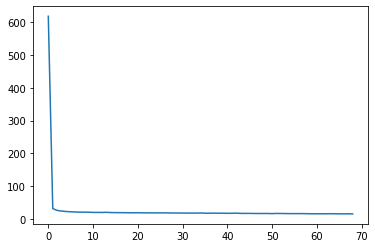

In [37]:
# plot losses
plt.plot(model.history['loss'])

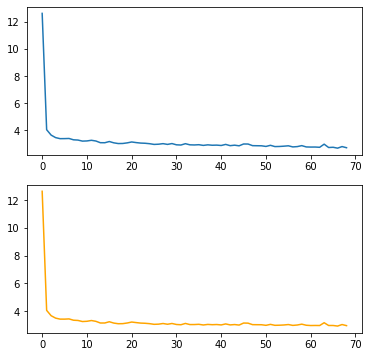

In [38]:
# plot accuracy
fig,ax = plt.subplots(2,1,figsize = (6,6))
ax[0].plot(model.history['train_mae'])
ax[1].plot(model.history['valid_mae'],c = 'orange')

In [39]:
# make submission
final_output = predictions.mean(axis = 1)
len(final_output)

291241

In [42]:
submission = pd.concat([test_id,pd.Series(final_output)],axis = 1).rename(columns = {0:'target'})
submission.to_csv('tabnet_best_sub.csv',index = False)

# Save and load Model

In [43]:
# save state dict
saved_filename = model.save_model('daycon_tabnet_best_model') # 이렇게 모델을 저장해서

Successfully saved model at daycon_tabnet_best_model.zip


In [44]:
model.best_cost

2.92544834829258

In [46]:
# define new model and load save parameters
loaded_model = TabNetRegressor()
loaded_model.load_model(saved_filename) # 모델을 불러올 수 있음.

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


# Global explainability : feat importance summing to 1

In [ ]:
model.feature_importances_

array([1.44616311e-01, 3.83249592e-03, 1.71473856e-03, 6.71472194e-02,
       4.85086397e-02, 8.51791433e-02, 1.17512090e-02, 1.19082099e-02,
       1.69347238e-03, 3.04054345e-03, 4.50005665e-02, 2.47810149e-02,
       5.40354152e-02, 9.23707522e-02, 2.45617465e-02, 2.79687127e-03,
       2.32566809e-03, 3.28334906e-02, 8.07027401e-03, 3.15112665e-03,
       1.45252205e-02, 1.90712205e-02, 7.76470225e-05, 0.00000000e+00,
       8.60640277e-03, 4.16098289e-02, 8.22129991e-03, 6.07743496e-03,
       5.42160660e-04, 9.72564095e-03, 1.65175007e-02, 1.85181848e-02,
       1.53009575e-02, 3.62618683e-03, 2.27344283e-03, 1.99758321e-02,
       1.03283516e-02, 6.47198046e-03, 1.40653606e-02, 1.25719116e-02,
       1.00854190e-02, 1.80223145e-03, 1.72092410e-04, 9.01351710e-03,
       4.01848115e-03, 9.78100640e-03, 2.36755335e-03, 1.16951465e-03,
       7.66293222e-03, 5.55323901e-03, 5.65461600e-03, 1.83187516e-03,
       3.69152592e-02, 6.54678946e-03])